# Ripple Detection Tutorial

---

## What You'll Learn

This tutorial will teach you how to:

1. **Understand** what sharp-wave ripples are and why they matter
2. **Simulate** synthetic ripple data for testing
3. **Preprocess** LFP signals for ripple detection
4. **Detect** ripples using multiple algorithms
5. **Compare** different detection methods
6. **Optimize** parameters for your specific data

---

## Prerequisites

**Required knowledge:**
- Basic Python and NumPy
- Understanding of neuroscience LFP recordings

**Estimated time:** 30-45 minutes

---

## Table of Contents

1. [Introduction to Sharp-Wave Ripples](#1.-Introduction-to-Sharp-Wave-Ripples)
2. [Setup and Installation](#2.-Setup-and-Installation)
3. [Simulating Ripple Data](#3.-Simulating-Ripple-Data)
4. [Signal Processing Basics](#4.-Signal-Processing-Basics)
5. [Basic Ripple Detection](#5.-Basic-Ripple-Detection)
6. [Comparing Detection Algorithms](#6.-Comparing-Detection-Algorithms)
7. [Working with Real Data](#7.-Working-with-Real-Data)
8. [Advanced Topics](#8.-Advanced-Topics)
9. [Summary and Best Practices](#9.-Summary-and-Best-Practices)

---

## 1. Introduction to Sharp-Wave Ripples

### What are Sharp-Wave Ripples?

**Sharp-wave ripples (SWRs)** are brief, high-frequency **ripple** oscillations (150-250 Hz)* in the hippocampal local field potential (LFP) accompanied by a **sharp wave**, a transient negative deflection in the LFP (1-4 Hz). They are:

- **Duration:** ~30-250 milliseconds
- **Frequency:** 150-250 Hz (ripple component) and ~1-4 Hz (sharp wave component)
- **Occurrence:** Primarily during quiet wakefulness and slow-wave sleep
- **Function:** Associated with memory consolidation and replay of spatial sequences

* Note: Frequency ranges may vary slightly based on species and experimental conditions.

### Why Detect Them?

SWRs are critical for:
- Understanding **memory formation** and **consolidation**
- Studying **hippocampal-cortical communication**
- Investigating **place cell reactivation**
- Clinical applications in **epilepsy research**

---

## 2. Setup and Installation

### Installation

```bash
# From PyPI (when available)
pip install ripple-detection

# From source (development)
git clone https://github.com/Eden-Kramer-Lab/ripple_detection.git
cd ripple_detection
pip install -e .[examples]
```

### Import Required Libraries

In [1]:
# Core scientific computing

# Visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ripple detection package
from ripple_detection import (
    Karlsson_ripple_detector,  # import specific detectors
    Kay_ripple_detector,
    Roumis_ripple_detector,
    filter_ripple_band,  # import utility functions
)
from ripple_detection.simulate import (
    simulate_LFP,
    simulate_time,
)  # import simulation functions

# Configure matplotlib for better-looking plots
plt.style.use("seaborn-v0_8-darkgrid")
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

print("✓ All imports successful!")

✓ All imports successful!


---

## 3. Simulating Ripple Data

Before working with real data, let's create synthetic data to understand how ripples look and how the package works.

### 3.1 Creating a Time Array

First, we need a time vector. In neuroscience, we typically collect data at a high sampling rate (20-30 kHz). We bandpass for the LFP (1-500 Hz), and downsample (because we don't need such high frequency for analysis and this saves space). Often **1500 Hz** or **1000 Hz** for hippocampal LFP bandpassed data is sufficient (Nyquist frequency of 750 Hz or 500 Hz, respectively).

In [2]:
# Create 5 seconds of data at 1500 Hz
sampling_frequency = 1500  # Hz
duration = 5.0  # seconds

time = simulate_time(n_samples=int(duration * sampling_frequency),
                     sampling_frequency=sampling_frequency)

print(f"Time array shape: {time.shape}")
print(f"Duration: {time[-1]:.2f} seconds")
print(f"Sampling rate: {1/np.median(np.diff(time)):.0f} Hz")

Time array shape: (7500,)
Duration: 5.00 seconds
Sampling rate: 1500 Hz


### 3.2 Simulating LFP with Ripples

Now let's create an LFP signal with ripples at specific times.

In [3]:
# Define when ripples should occur (in seconds)
ripple_times = [1.0, 2.5, 4.0]

# Simulate LFP with ripples
lfp = simulate_LFP(
    time=time,
    ripple_times=ripple_times,
    ripple_amplitude=3.0,      # Ripple strength
    noise_amplitude=1.0,       # Background noise
    ripple_duration=0.100,     # 100 ms ripples
    noise_type='brown'         # Brown noise (1/f²) mimics neural activity
)

print(f"LFP shape: {lfp.shape}")
print(f"Number of simulated ripples: {len(ripple_times)}")

LFP shape: (7500,)
Number of simulated ripples: 3


### 3.3 Visualizing the Simulated Data

Let's plot the LFP to see what ripples look like in the raw signal.

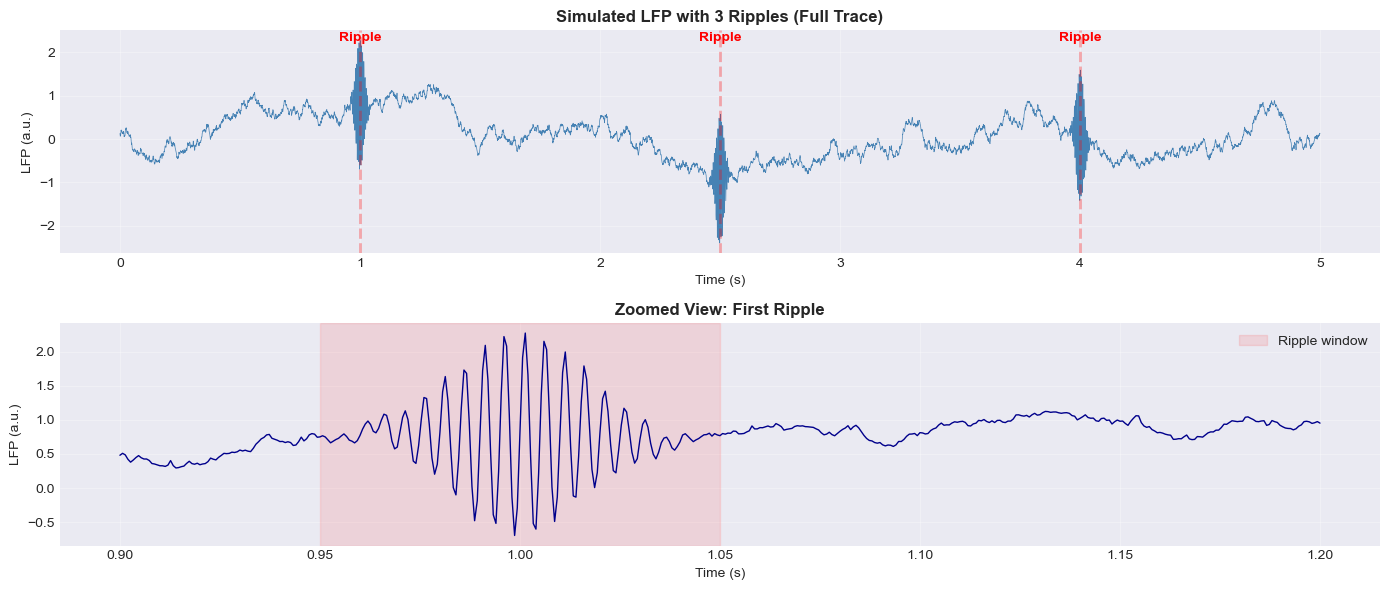

💡 Notice: Ripples appear as brief bursts of high-frequency activity!


In [4]:
fig, axes = plt.subplots(2, 1, figsize=(14, 6))

# Plot 1: Full 5-second trace
axes[0].plot(time, lfp, linewidth=0.5, color='steelblue')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('LFP (a.u.)')
axes[0].set_title('Simulated LFP with 3 Ripples (Full Trace)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Mark ripple times
for ripple_time in ripple_times:
    axes[0].axvline(ripple_time, color='red', alpha=0.3, linestyle='--', linewidth=2)
    axes[0].text(ripple_time, axes[0].get_ylim()[1]*0.9, 'Ripple',
                ha='center', color='red', fontweight='bold')

# Plot 2: Zoom into first ripple
zoom_start, zoom_end = 0.9, 1.2
zoom_mask = (time >= zoom_start) & (time <= zoom_end)
axes[1].plot(time[zoom_mask], lfp[zoom_mask], linewidth=1, color='darkblue')
axes[1].axvspan(0.95, 1.05, color='red', alpha=0.1, label='Ripple window')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('LFP (a.u.)')
axes[1].set_title('Zoomed View: First Ripple', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 Notice: Ripples appear as brief bursts of high-frequency activity!")

**🔍 Key Observations:**
- Ripples are **brief** (~100 ms)
- They have **high frequency** oscillations
- They're embedded in **background noise**
- In the real raw LFP, they can be hard to see! Particularly if the noise level is high and they are riding on a sharp wave.


Here's an example from real data:

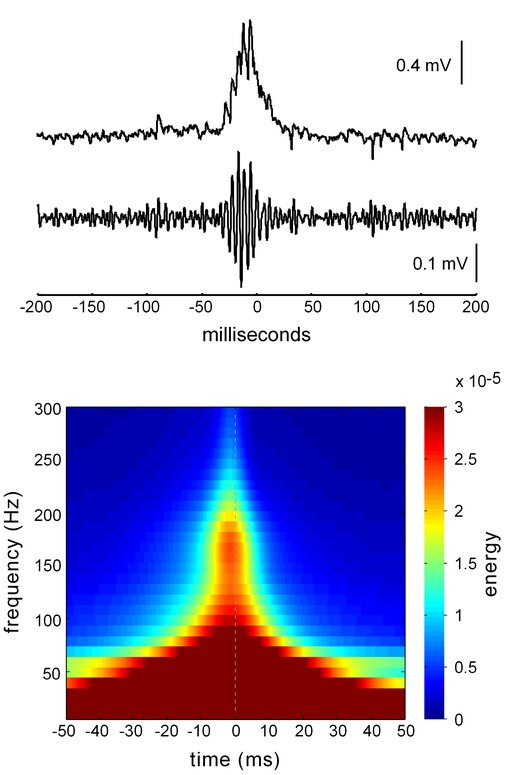

Credit: 
> C.S. Rex - Rex CS, Colgin LL, Jia Y, Casale M, Yanagihara TK, Debenedetti M, et al. (2009) Origins of an Intrinsic Hippocampal EEG Pattern. PLoS ONE 4(11): e7761. https://doi.org/10.1371/journal.pone.0007761

Also see this for more examples:
> Buzsáki G. Hippocampal sharp wave-ripple: A cognitive biomarker for episodic memory and planning. Hippocampus. 2015 Oct;25(10):1073-188. doi: 10.1002/hipo.22488. PMID: 26135716; PMCID: PMC4648295.

---

## 4. Signal Processing Basics

To detect ripples, we need to isolate the 150-250 Hz frequency band. This is called **bandpass filtering**.

### 4.1 Filtering the Ripple Band

The package provides a pre-computed filter optimized for 1500 Hz sampling.

In [5]:
# Filter the LFP to isolate ripple frequencies (150-250 Hz)
# Reshape to 2D: (n_time, n_channels) - required format
lfp_2d = lfp.reshape(-1, 1)  # Single channel

# Apply bandpass filter
filtered_lfp = filter_ripple_band(lfp_2d)

print(f"Filtered LFP shape: {filtered_lfp.shape}")
print("✓ Bandpass filtering complete!")

Filtered LFP shape: (7500, 1)
✓ Bandpass filtering complete!


### 4.2 Comparing Raw vs. Filtered Signal

Let's see how filtering reveals the ripples more clearly.

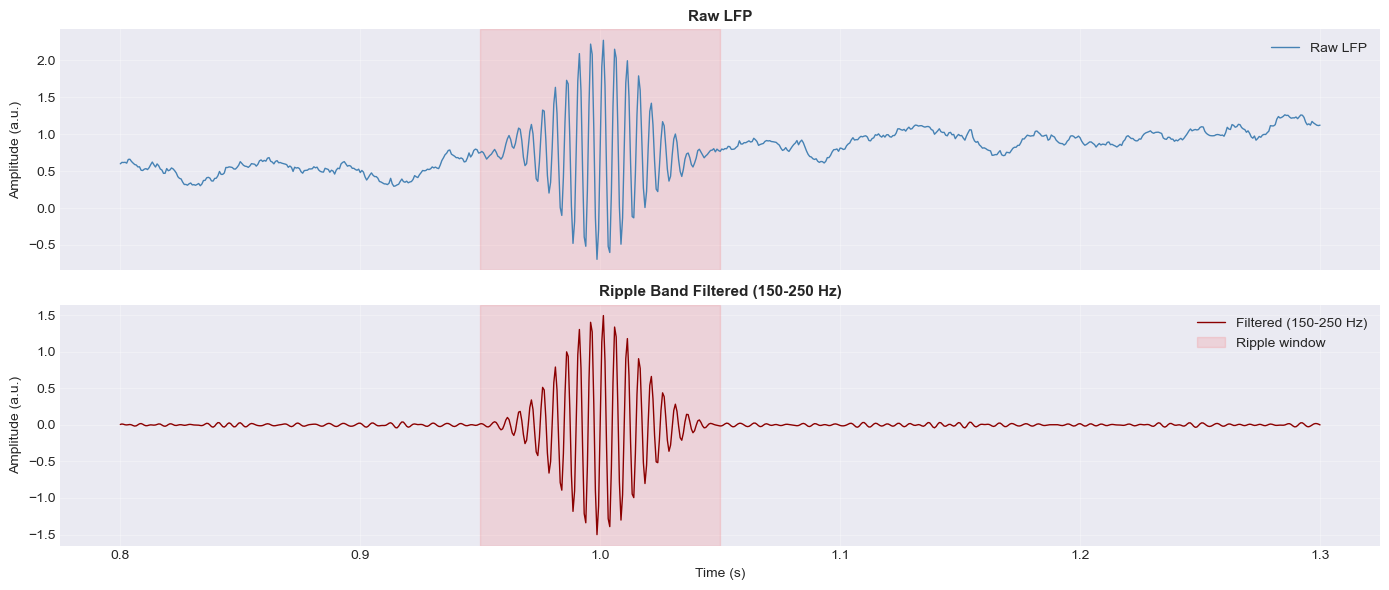

💡 After filtering, the ripple oscillations are much more prominent!


In [6]:
fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

# Zoom window around first ripple
zoom_start, zoom_end = 0.8, 1.3
zoom_mask = (time >= zoom_start) & (time <= zoom_end)

# Raw LFP
axes[0].plot(time[zoom_mask], lfp[zoom_mask], linewidth=1, color='steelblue', label='Raw LFP')
axes[0].axvspan(0.95, 1.05, color='red', alpha=0.1)
axes[0].set_ylabel('Amplitude (a.u.)')
axes[0].set_title('Raw LFP', fontsize=11, fontweight='bold')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Filtered LFP (ripple band)
axes[1].plot(time[zoom_mask], filtered_lfp[zoom_mask, 0], linewidth=1, color='darkred', label='Filtered (150-250 Hz)')
axes[1].axvspan(0.95, 1.05, color='red', alpha=0.1, label='Ripple window')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Amplitude (a.u.)')
axes[1].set_title('Ripple Band Filtered (150-250 Hz)', fontsize=11, fontweight='bold')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 After filtering, the ripple oscillations are much more prominent!")

**🔍 Key Observations:**
- **Raw LFP**: Contains all frequencies (0-750 Hz)
- **Filtered LFP**: Only 150-250 Hz, ripples stand out clearly
- Filtering is **essential** for ripple detection

---

## 5. Basic Ripple Detection

Now let's detect ripples! We'll start with the **Kay detector**, which uses a multi-channel consensus approach.

### 5.1 Creating a Speed Signal

Ripples typically occur when the animal is **stationary or moving slowly**. We need to provide speed information.

In [7]:
# Create speed signal (in cm/s)
# Simulate animal being mostly stationary (low speed)
speed = np.ones(len(time)) * 2.0  # 2 cm/s (stationary)

# Add some movement periods
movement_mask = (time > 3.2) & (time < 3.8)
speed[movement_mask] = 8.0  # 8 cm/s (moving)

print(f"Speed signal shape: {speed.shape}")
print(f"Speed range: {speed.min():.1f} - {speed.max():.1f} cm/s")

Speed signal shape: (7500,)
Speed range: 2.0 - 8.0 cm/s


### 5.2 Running the Kay Ripple Detector

The Kay detector needs:
- **time**: Time array (seconds)
- **filtered_lfps**: Bandpass filtered LFP
- **speed**: Animal speed (cm/s)
- **sampling_frequency**: Hz

Key parameters:
- **speed_threshold**: Exclude events when speed > 4 cm/s (default)
- **minimum_duration**: Ripples must last at least 15 ms (default)
- **zscore_threshold**: Signal must be > 2 SD above baseline (default)


#### Notes
- The speed threshold requires the speed at the start and end of the ripple to be below the threshold (doesn't have to be below throughout).
- The z-score threshold requires the ripple envelope to exceed the threshold at some point during the event.
- The start and end of the ripple are defined as the points where the envelope crosses back below the mean level.

In [8]:
# Detect ripples using Kay algorithm
detected_ripples = Kay_ripple_detector(
    time=time,
    filtered_lfps=filtered_lfp,
    speed=speed,
    sampling_frequency=sampling_frequency,
    speed_threshold=4.0,      # Exclude if speed > 4 cm/s
    minimum_duration=0.015,   # Minimum 15 ms
    zscore_threshold=2.0      # 2 standard deviations
)

print("\n✓ Detection complete!")
print(f"  Number of ripples detected: {len(detected_ripples)}")
print(f"  True number of ripples: {len(ripple_times)}")
print("\nFirst few detected ripples:")
display(detected_ripples.head())


✓ Detection complete!
  Number of ripples detected: 3
  True number of ripples: 3

First few detected ripples:


,start_time,end_time,duration,max_thresh,mean_zscore,median_zscore,max_zscore,min_zscore,area,total_energy,speed_at_start,speed_at_end,max_speed,min_speed,median_speed,mean_speed
event_number,,,,,,,,,,,,,,,,
1,0.955333,1.044667,0.089333,6.580022,3.415775,3.066481,7.346886,0.005865,0.307414,1.624668,2.0,2.0,2.0,2.0,2.0,2.0
2,2.452000,2.544667,0.092667,6.570969,3.253564,2.779271,7.235629,0.002430,0.303661,1.584632,2.0,2.0,2.0,2.0,2.0,2.0
3,3.954667,4.046000,0.091333,6.590730,3.317523,2.917146,7.333162,0.002674,0.305204,1.606220,2.0,2.0,2.0,2.0,2.0,2.0


### 5.3 Understanding the Output

The detector returns a **pandas DataFrame** with rich statistics for each ripple:

| Column | Description |
|--------|-------------|
| `start_time` | When the ripple began (seconds) |
| `end_time` | When the ripple ended (seconds) |
| `duration` | How long it lasted (seconds) |
| `max_thresh` | Maximum threshold crossed that would trigger detection |
| `mean_zscore` | Average signal strength (SD above baseline) |
| `median_zscore` | Median signal strength (SD above baseline) |
| `max_zscore` | Peak signal strength |
| `min_zscore` | Minimum signal strength |
| `area` | Integrated ripple power |
| `total_energy` | Total energy of the ripple |
| `speed_at_start` | Animal's speed when ripple began (cm/s) |
| `speed_at_end` | Animal's speed when ripple ended (cm/s) |
| `max_speed` | Maximum speed during the ripple (cm/s) |
| `min_speed` | Minimum speed during the ripple (cm/s) |
| `median_speed` | Median speed during the ripple (cm/s) |
| `mean_speed` | Average speed during the ripple (cm/s) |

In [9]:
# Calculate detection accuracy
if len(detected_ripples) > 0:
    # For each true ripple, check if we detected it (within ±100ms)
    detected_count = 0
    for true_time in ripple_times:
        for _, ripple in detected_ripples.iterrows():
            if abs(ripple['start_time'] - true_time) < 0.1:
                detected_count += 1
                break

    print(f"Detection rate: {detected_count}/{len(ripple_times)} ({100*detected_count/len(ripple_times):.0f}%)")
    print(f"False positives: {len(detected_ripples) - detected_count}")

Detection rate: 3/3 (100%)
False positives: 0


### 5.4 Visualizing Detected Ripples

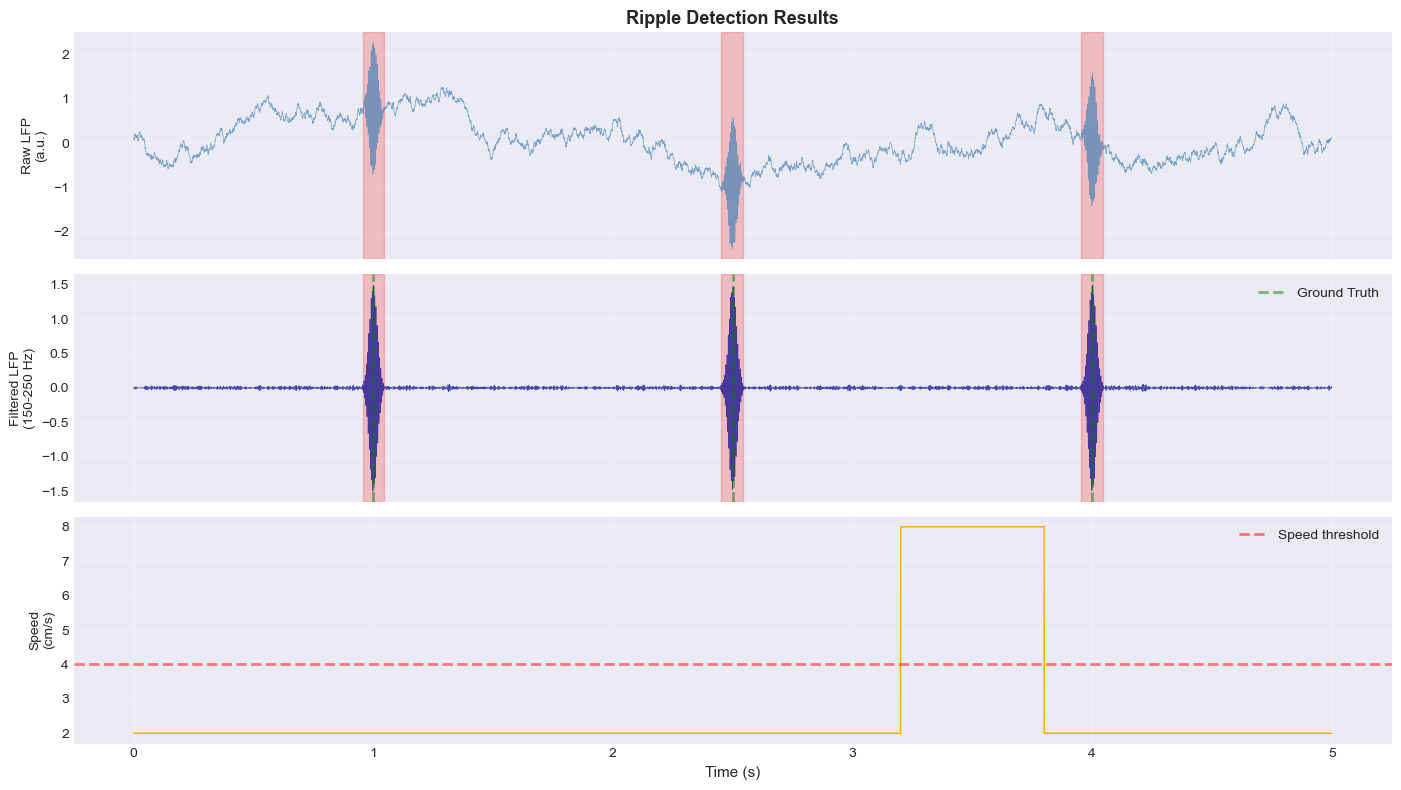

💡 Red shaded regions = detected ripples
💡 Green dashed lines = true ripple times
💡 Notice: Ripples during movement (speed > 4 cm/s) are excluded!


In [10]:
fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)

# Plot 1: Raw LFP
axes[0].plot(time, lfp, linewidth=0.5, color='steelblue', alpha=0.7)
axes[0].set_ylabel('Raw LFP\n(a.u.)', fontsize=10)
axes[0].set_title('Ripple Detection Results', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot 2: Filtered LFP with detections
axes[1].plot(time, filtered_lfp[:, 0], linewidth=0.5, color='darkblue', alpha=0.7)
axes[1].set_ylabel('Filtered LFP\n(150-250 Hz)', fontsize=10)
axes[1].grid(True, alpha=0.3)

# Highlight detected ripples
for _, ripple in detected_ripples.iterrows():
    axes[0].axvspan(ripple['start_time'], ripple['end_time'],
                    color='red', alpha=0.2)
    axes[1].axvspan(ripple['start_time'], ripple['end_time'],
                    color='red', alpha=0.2, label='Detected' if _ == 0 else '')

# Mark ground truth
for ripple_time in ripple_times:
    axes[1].axvline(ripple_time, color='green', linestyle='--', alpha=0.5, linewidth=2,
                   label='Ground Truth' if ripple_time == ripple_times[0] else '')

axes[1].legend(loc='upper right')

# Plot 3: Speed
axes[2].plot(time, speed, linewidth=1, color='orange')
axes[2].axhline(4.0, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Speed threshold')
axes[2].set_xlabel('Time (s)', fontsize=11)
axes[2].set_ylabel('Speed\n(cm/s)', fontsize=10)
axes[2].legend(loc='upper right')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 Red shaded regions = detected ripples")
print("💡 Green dashed lines = true ripple times")
print("💡 Notice: Ripples during movement (speed > 4 cm/s) are excluded!")

---

## 6. Comparing Detection Algorithms

The package provides **three different detection algorithms**, each with unique strengths:

1. **Kay (2016)**: Multi-channel consensus - best for multi-channel recordings
2. **Karlsson (2009)**: Per-channel detection with merging - robust to channel variability
3. **Roumis**: Variant approach - good for single-channel data

### 6.1 Creating Multi-Channel Test Data

Let's simulate 3 channels with ripples at the same times.

In [11]:
# Simulate 3 LFP channels
n_channels = 3
lfps_multi = []

for ch in range(n_channels):
    # Each channel has slightly different amplitude and noise
    lfp_ch = simulate_LFP(
        time=time,
        ripple_times=ripple_times,
        ripple_amplitude=3.0 - ch*0.5,  # Decreasing amplitude
        noise_amplitude=1.0,
        ripple_duration=0.100,
        noise_type='brown'
    )
    lfps_multi.append(lfp_ch)

# Stack into 2D array: (n_time, n_channels)
lfps_multi = np.column_stack(lfps_multi)
filtered_lfps_multi = filter_ripple_band(lfps_multi)

print(f"Multi-channel LFP shape: {lfps_multi.shape}")
print(f"  {lfps_multi.shape[0]} time points")
print(f"  {lfps_multi.shape[1]} channels")

Multi-channel LFP shape: (7500, 3)
  7500 time points
  3 channels


### 6.2 Running All Three Detectors

In [12]:
# Common parameters
detector_params = {
    'time': time,
    'filtered_lfps': filtered_lfps_multi,
    'speed': speed,
    'sampling_frequency': sampling_frequency,
    'speed_threshold': 4.0,
    'minimum_duration': 0.015,
    'zscore_threshold': 2.0
}

# Run all three detectors
print("Running detectors...\n")

kay_results = Kay_ripple_detector(**detector_params)
print(f"✓ Kay detector: {len(kay_results)} ripples detected")

karlsson_results = Karlsson_ripple_detector(**detector_params)
print(f"✓ Karlsson detector: {len(karlsson_results)} ripples detected")

roumis_results = Roumis_ripple_detector(**detector_params)
print(f"✓ Roumis detector: {len(roumis_results)} ripples detected")

print(f"\nGround truth: {len(ripple_times)} ripples")

Running detectors...

✓ Kay detector: 3 ripples detected
✓ Karlsson detector: 3 ripples detected
✓ Roumis detector: 3 ripples detected

Ground truth: 3 ripples


### 6.3 Comparing Results

In [13]:
# Create comparison DataFrame
comparison = pd.DataFrame({
    'Detector': ['Kay', 'Karlsson', 'Roumis'],
    'N_Detected': [len(kay_results), len(karlsson_results), len(roumis_results)],
    'Avg_Duration_ms': [
        kay_results['duration'].mean() * 1000 if len(kay_results) > 0 else 0,
        karlsson_results['duration'].mean() * 1000 if len(karlsson_results) > 0 else 0,
        roumis_results['duration'].mean() * 1000 if len(roumis_results) > 0 else 0
    ],
    'Avg_Zscore': [
        kay_results['mean_zscore'].mean() if len(kay_results) > 0 else 0,
        karlsson_results['mean_zscore'].mean() if len(karlsson_results) > 0 else 0,
        roumis_results['mean_zscore'].mean() if len(roumis_results) > 0 else 0
    ]
})

print("\n" + "="*60)
print("DETECTOR COMPARISON")
print("="*60)
print(comparison.to_string(index=False))
print("="*60)


DETECTOR COMPARISON
Detector  N_Detected  Avg_Duration_ms  Avg_Zscore
     Kay           3        89.555556    3.373874
Karlsson           3        92.444444    3.224389
  Roumis           3        89.555556    3.374164


### 6.4 Visual Comparison

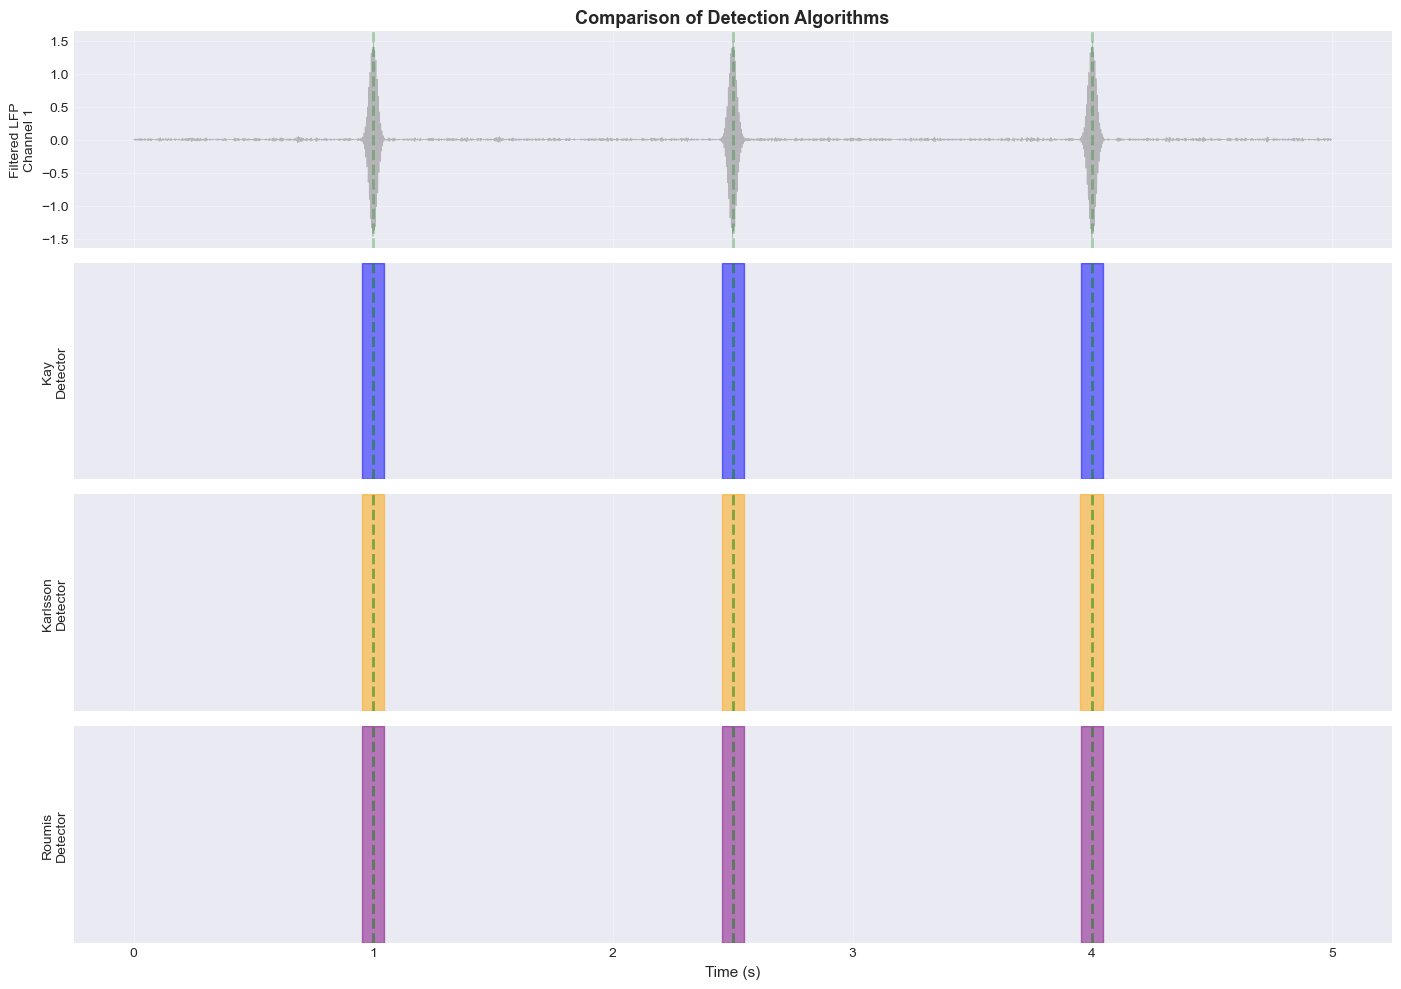

💡 Green dashed lines = ground truth ripple times
💡 Colored regions = detections from each algorithm


In [14]:
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# Plot filtered LFP (channel 0)
axes[0].plot(time, filtered_lfps_multi[:, 0], linewidth=0.5, color='gray', alpha=0.5)
axes[0].set_ylabel('Filtered LFP\nChannel 1', fontsize=10)
axes[0].set_title('Comparison of Detection Algorithms', fontsize=13, fontweight='bold')
for rt in ripple_times:
    axes[0].axvline(rt, color='green', linestyle='--', alpha=0.3, linewidth=2)
axes[0].grid(True, alpha=0.3)

# Kay detections
axes[1].set_ylabel('Kay\nDetector', fontsize=10)
axes[1].set_ylim(0, 1)
axes[1].set_yticks([])
for _, ripple in kay_results.iterrows():
    axes[1].axvspan(ripple['start_time'], ripple['end_time'], color='blue', alpha=0.5)
axes[1].grid(True, alpha=0.3)

# Karlsson detections
axes[2].set_ylabel('Karlsson\nDetector', fontsize=10)
axes[2].set_ylim(0, 1)
axes[2].set_yticks([])
for _, ripple in karlsson_results.iterrows():
    axes[2].axvspan(ripple['start_time'], ripple['end_time'], color='orange', alpha=0.5)
axes[2].grid(True, alpha=0.3)

# Roumis detections
axes[3].set_ylabel('Roumis\nDetector', fontsize=10)
axes[3].set_ylim(0, 1)
axes[3].set_yticks([])
for _, ripple in roumis_results.iterrows():
    axes[3].axvspan(ripple['start_time'], ripple['end_time'], color='purple', alpha=0.5)
axes[3].set_xlabel('Time (s)', fontsize=11)
axes[3].grid(True, alpha=0.3)

# Add ground truth markers
for ax in axes[1:]:
    for rt in ripple_times:
        ax.axvline(rt, color='green', linestyle='--', alpha=0.5, linewidth=2)

plt.tight_layout()
plt.show()

print("💡 Green dashed lines = ground truth ripple times")
print("💡 Colored regions = detections from each algorithm")

**🔍 Which Detector to Use?**

- **Kay**: Best for clean multi-channel data, consensus approach reduces false positives
- **Karlsson**: Good when channels have variable quality, merges per-channel detections
- **Roumis**: Alternative approach, can be more sensitive but may have more false positives

**Recommendation**: Start with Kay, then try others if results aren't satisfactory.

---

## 7. Working with Real Data

### 7.1 Data Requirements

Your data should have:

1. **LFP signal**: Raw voltage recordings from hippocampal electrodes
2. **Time array**: Timestamps in **seconds** (not samples!)
3. **Speed data**: Animal's movement speed in **cm/s** (not m/s!)
4. **Sampling frequency**: Typically 1500 Hz or 2000 Hz

### 7.2 Loading Your Data

```python
# Example: Loading from numpy files
your_lfp = np.load('your_lfp_data.npy')  # Shape: (n_samples, n_channels)
your_time = np.load('your_time.npy')      # Shape: (n_samples,)
your_speed = np.load('your_speed.npy')    # Shape: (n_samples,)

# Or from pandas/HDF5/etc.
```

### 7.3 Preprocessing Pipeline

In [15]:
def preprocess_and_detect_ripples(lfp, time, speed, sampling_frequency=1500):
    """
    Complete pipeline for ripple detection.

    Parameters
    ----------
    lfp : array_like, shape (n_samples, n_channels)
        Raw LFP data
    time : array_like, shape (n_samples,)
        Time in seconds
    speed : array_like, shape (n_samples,)
        Speed in cm/s
    sampling_frequency : float
        Sampling rate in Hz

    Returns
    -------
    ripples : pd.DataFrame
        Detected ripple events
    filtered_lfp : np.ndarray
        Bandpass filtered LFP
    """

    # 1. Ensure correct shape
    if lfp.ndim == 1:
        lfp = lfp.reshape(-1, 1)

    print(f"Step 1: Data shape = {lfp.shape}")

    # 2. Bandpass filter to ripple band (150-250 Hz)
    filtered_lfp = filter_ripple_band(lfp)
    print("Step 2: ✓ Filtered to 150-250 Hz")

    # 3. Detect ripples
    ripples = Kay_ripple_detector(
        time=time,
        filtered_lfps=filtered_lfp,
        speed=speed,
        sampling_frequency=sampling_frequency,
        speed_threshold=4.0,
        minimum_duration=0.015,
        zscore_threshold=2.0
    )

    print(f"Step 3: ✓ Detected {len(ripples)} ripples")

    return ripples, filtered_lfp

# Example usage:
example_ripples, example_filtered = preprocess_and_detect_ripples(
    lfp=lfps_multi,
    time=time,
    speed=speed,
    sampling_frequency=sampling_frequency
)

print("\n✓ Pipeline complete!")

Step 1: Data shape = (7500, 3)
Step 2: ✓ Filtered to 150-250 Hz
Step 3: ✓ Detected 3 ripples

✓ Pipeline complete!


### 7.4 Common Issues and Solutions

**Issue 1: "Time array appears to be in samples"**
```python
# Fix: Convert samples to seconds
time_seconds = sample_indices / sampling_frequency
```

**Issue 2: "Speed values appear very small"**
```python
# Fix: Convert m/s to cm/s
speed_cms = speed_ms * 100
```

**Issue 3: "filtered_lfps must be 2D"**
```python
# Fix: Reshape 1D to 2D
lfp_2d = lfp_1d.reshape(-1, 1)
```

**Issue 4: "No ripples detected"**
- Lower `zscore_threshold` (try 1.5)
- Lower `minimum_duration` (try 0.010)
- Check your speed threshold
- Verify data quality

---

## 8. Advanced Topics

### 8.1 Parameter Optimization

How do you choose the right parameters? Let's explore sensitivity.


Parameter Sensitivity Analysis
 threshold  n_detected  avg_duration_ms  avg_zscore
       1.0           3        89.555556    3.373874
       1.5           3        89.555556    3.373874
       2.0           3        89.555556    3.373874
       2.5           3        89.555556    3.373874
       3.0           3        89.555556    3.373874


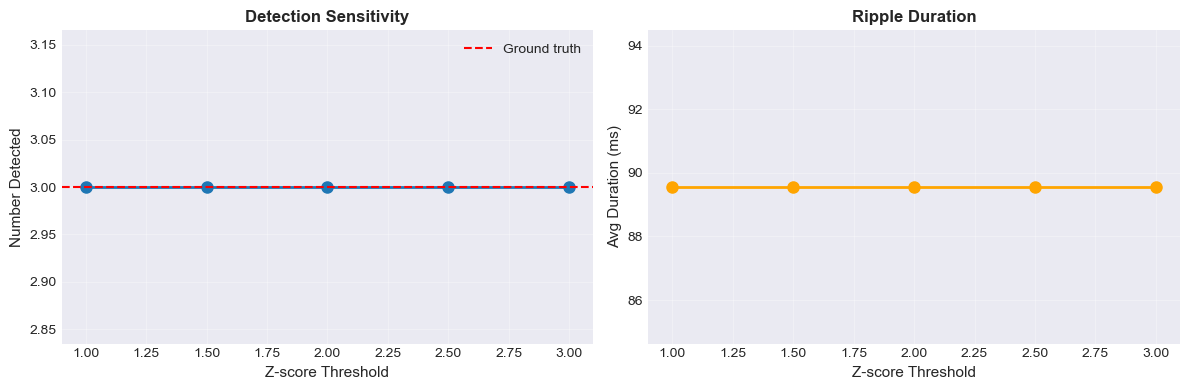


💡 Lower threshold = more detections but more false positives
💡 Higher threshold = fewer detections but higher confidence


In [16]:
# Test different z-score thresholds
thresholds = [1.0, 1.5, 2.0, 2.5, 3.0]
results = []

for thresh in thresholds:
    ripples = Kay_ripple_detector(
        time=time,
        filtered_lfps=filtered_lfps_multi,
        speed=speed,
        sampling_frequency=sampling_frequency,
        zscore_threshold=thresh
    )
    results.append({
        'threshold': thresh,
        'n_detected': len(ripples),
        'avg_duration_ms': ripples['duration'].mean() * 1000 if len(ripples) > 0 else 0,
        'avg_zscore': ripples['mean_zscore'].mean() if len(ripples) > 0 else 0
    })

param_df = pd.DataFrame(results)
print("\nParameter Sensitivity Analysis")
print("="*60)
print(param_df.to_string(index=False))
print("="*60)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(param_df['threshold'], param_df['n_detected'], 'o-', linewidth=2, markersize=8)
axes[0].axhline(len(ripple_times), color='red', linestyle='--', label='Ground truth')
axes[0].set_xlabel('Z-score Threshold', fontsize=11)
axes[0].set_ylabel('Number Detected', fontsize=11)
axes[0].set_title('Detection Sensitivity', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(param_df['threshold'], param_df['avg_duration_ms'], 'o-',
            linewidth=2, markersize=8, color='orange')
axes[1].set_xlabel('Z-score Threshold', fontsize=11)
axes[1].set_ylabel('Avg Duration (ms)', fontsize=11)
axes[1].set_title('Ripple Duration', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Lower threshold = more detections but more false positives")
print("💡 Higher threshold = fewer detections but higher confidence")

### 8.2 Custom Normalization

Sometimes you want to normalize based on specific periods (e.g., only immobility).

The detectors support custom normalization masks:

In [17]:
# Detect ripples using only immobility periods for normalization
immobility_mask = speed < 4.0

ripples_custom_norm = Kay_ripple_detector(
    time=time,
    filtered_lfps=filtered_lfps_multi,
    speed=speed,
    sampling_frequency=sampling_frequency,
    normalization_mask=immobility_mask  # Compute statistics only during immobility
)

print(f"Standard detection: {len(detected_ripples)} ripples")
print(f"Custom normalization: {len(ripples_custom_norm)} ripples")
print("\n💡 Custom normalization can improve detection in noisy data!")

Standard detection: 3 ripples
Custom normalization: 3 ripples

💡 Custom normalization can improve detection in noisy data!


### 8.3 Analyzing Ripple Statistics

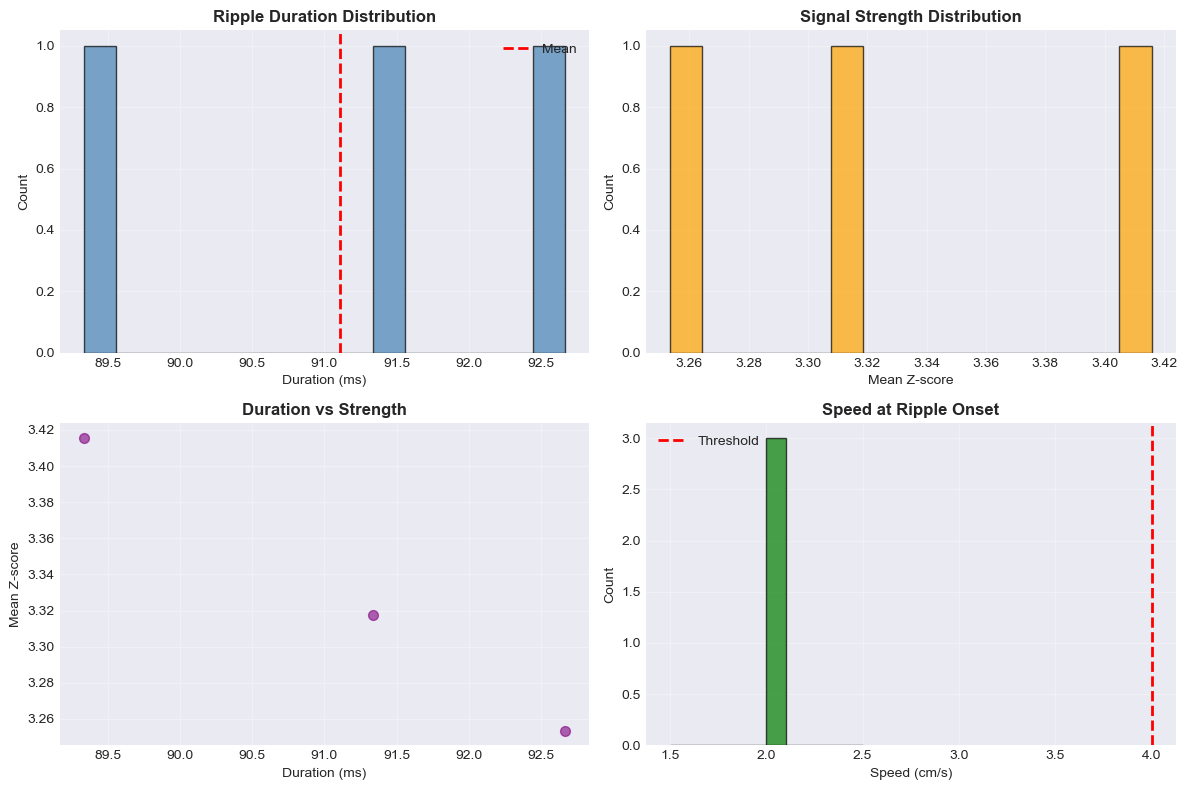


RIPPLE STATISTICS SUMMARY
Number of ripples: 3

Duration:
  Mean: 91.1 ms
  Std:  1.7 ms
  Range: 89.3 - 92.7 ms

Signal Strength (Z-score):
  Mean: 3.33
  Max:  7.35

Speed at onset:
  Mean: 2.00 cm/s


In [18]:
if len(detected_ripples) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Duration distribution
    axes[0, 0].hist(detected_ripples['duration'] * 1000, bins=15,
                    color='steelblue', edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('Duration (ms)', fontsize=10)
    axes[0, 0].set_ylabel('Count', fontsize=10)
    axes[0, 0].set_title('Ripple Duration Distribution', fontweight='bold')
    axes[0, 0].axvline(detected_ripples['duration'].mean() * 1000,
                      color='red', linestyle='--', linewidth=2, label='Mean')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Z-score distribution
    axes[0, 1].hist(detected_ripples['mean_zscore'], bins=15,
                    color='orange', edgecolor='black', alpha=0.7)
    axes[0, 1].set_xlabel('Mean Z-score', fontsize=10)
    axes[0, 1].set_ylabel('Count', fontsize=10)
    axes[0, 1].set_title('Signal Strength Distribution', fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)

    # Duration vs Z-score
    axes[1, 0].scatter(detected_ripples['duration'] * 1000,
                      detected_ripples['mean_zscore'],
                      s=50, alpha=0.6, color='purple')
    axes[1, 0].set_xlabel('Duration (ms)', fontsize=10)
    axes[1, 0].set_ylabel('Mean Z-score', fontsize=10)
    axes[1, 0].set_title('Duration vs Strength', fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)

    # Speed at detection
    axes[1, 1].hist(detected_ripples['speed_at_start'], bins=10,
                    color='green', edgecolor='black', alpha=0.7)
    axes[1, 1].set_xlabel('Speed (cm/s)', fontsize=10)
    axes[1, 1].set_ylabel('Count', fontsize=10)
    axes[1, 1].set_title('Speed at Ripple Onset', fontweight='bold')
    axes[1, 1].axvline(4.0, color='red', linestyle='--',
                      linewidth=2, label='Threshold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n" + "="*60)
    print("RIPPLE STATISTICS SUMMARY")
    print("="*60)
    print(f"Number of ripples: {len(detected_ripples)}")
    print("\nDuration:")
    print(f"  Mean: {detected_ripples['duration'].mean()*1000:.1f} ms")
    print(f"  Std:  {detected_ripples['duration'].std()*1000:.1f} ms")
    print(f"  Range: {detected_ripples['duration'].min()*1000:.1f} - {detected_ripples['duration'].max()*1000:.1f} ms")
    print("\nSignal Strength (Z-score):")
    print(f"  Mean: {detected_ripples['mean_zscore'].mean():.2f}")
    print(f"  Max:  {detected_ripples['max_zscore'].max():.2f}")
    print("\nSpeed at onset:")
    print(f"  Mean: {detected_ripples['speed_at_start'].mean():.2f} cm/s")
    print("="*60)
else:
    print("No ripples detected for analysis.")

---

## 9. Summary and Best Practices

### 🎯 Key Takeaways

1. **Sharp-wave ripples** are brief (50-150 ms), high-frequency (150-250 Hz) hippocampal events
2. **Bandpass filtering** to 150-250 Hz is essential before detection
3. **Three detection algorithms** are available, each with strengths:
   - Kay: Multi-channel consensus
   - Karlsson: Per-channel with merging
   - Roumis: Alternative approach
4. **Speed thresholding** (default: 4 cm/s) excludes movement periods
5. **Parameter tuning** is important for your specific data

### ✅ Best Practices Checklist

**Data Preparation:**
- ☑ Time in **seconds** (not samples)
- ☑ Speed in **cm/s** (not m/s)
- ☑ LFP in 2D format: `(n_time, n_channels)`
- ☑ Sampling frequency ≥ 1000 Hz (ideally 1500 Hz)

**Detection:**
- ☑ Always bandpass filter first
- ☑ Start with default parameters
- ☑ Try Kay detector first
- ☑ Compare multiple detectors if unsure
- ☑ Validate on known data if possible

**Parameter Tuning:**
- ☑ Lower `zscore_threshold` if missing ripples (try 1.5)
- ☑ Adjust `speed_threshold` based on your behavior paradigm
- ☑ Adjust `minimum_duration` based on expected ripple lengths
- ☑ Use `normalization_mask` for noisy or non-stationary data

**Quality Control:**
- ☑ Visually inspect detections
- ☑ Check duration distributions (should be 50-150 ms)
- ☑ Verify speed at detection (should be < threshold)
- ☑ Compare with manual annotations if available

### 📚 Further Reading

**Key Papers:**
1. **Karlsson & Frank (2009)** - Awake replay of remote experiences
2. **Kay et al. (2016)** - Network for spatial coding during immobility
3. **Buzsáki (2015)** - Hippocampal sharp wave-ripple: A cognitive biomarker

**Package Documentation:**
- GitHub: https://github.com/Eden-Kramer-Lab/ripple_detection
- Additional examples in `examples/` directory

### 💡 Next Steps

Now that you understand ripple detection:
1. Try the package on your own data
2. Experiment with different parameters
3. Compare detection algorithms
4. Analyze ripple statistics in your paradigm
5. Correlate ripples with behavior or neural activity

### 🤝 Getting Help

If you encounter issues:
- Check the [GitHub Issues](https://github.com/Eden-Kramer-Lab/ripple_detection/issues)
- Review the [API documentation](https://github.com/Eden-Kramer-Lab/ripple_detection)
- Open a new issue with a minimal reproducible example

---

**Happy Ripple Detecting! 🌊**

---

## Appendix: Quick Reference

### Common Code Snippets

**Complete Pipeline:**
```python
from ripple_detection import filter_ripple_band, Kay_ripple_detector

# 1. Filter
filtered_lfp = filter_ripple_band(your_lfp)  # your_lfp: (n_time, n_channels)

# 2. Detect
ripples = Kay_ripple_detector(
    time=your_time,              # seconds
    filtered_lfps=filtered_lfp,
    speed=your_speed,            # cm/s
    sampling_frequency=1500,
    speed_threshold=4.0,
    minimum_duration=0.015,
    zscore_threshold=2.0
)

# 3. Analyze
print(f"Detected {len(ripples)} ripples")
print(f"Avg duration: {ripples['duration'].mean()*1000:.1f} ms")
```

**Troubleshooting:**
```python
# Fix time units
time_seconds = sample_indices / sampling_frequency

# Fix speed units
speed_cms = speed_ms * 100

# Fix LFP shape
lfp_2d = lfp_1d.reshape(-1, 1)

# Lower threshold if no detections
ripples = Kay_ripple_detector(..., zscore_threshold=1.5)
```